In [269]:
import circgenerator as cg
from checksfinder import get_error_mitig_circ

from qiskit import QuantumCircuit, transpile, ClassicalRegister
# from qiskit_aer import AerSimulator
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram

from qiskit.providers.aer.noise import depolarizing_error, NoiseModel


In [270]:
def circ_without_noise(circ, num_shots):
    circ_with_measurement = circ.copy('circ_with_measurement')
    circ_with_measurement.measure_all()
    backend = AerSimulator(method='statevector')
    compiled_circuit = transpile(circ_with_measurement, backend, optimization_level=0)
    job = backend.run(compiled_circuit, shots=num_shots)
    count = job.result().get_counts(circ_with_measurement)
    return count

In [271]:
def circ_with_noise(circ, noise_model, num_shots):
    circ_with_measurement = circ.copy('circ_with_measurement')
    circ_with_measurement.measure_all()
    backend = AerSimulator(method='statevector', noise_model=noise_model)
    compiled_circuit = transpile(circ_with_measurement, backend, optimization_level=0)
    job = backend.run(compiled_circuit, shots=num_shots)
    count = job.result().get_counts(circ_with_measurement)
    return count

In [272]:
def circ_with_noise_pcs(circ, noise_model, levels, num_shots):
    n_qubits = circ.num_qubits
    qem_qasm = get_error_mitig_circ(circ.qasm(), levels)
    qem_circ = QuantumCircuit.from_qasm_str(qem_qasm)
    
    crs = ClassicalRegister(n_qubits)
    qem_circ.add_register(crs)
    for i, qubit in enumerate(qem_circ.qubits[:n_qubits]):
        qem_circ.measure(qubit, crs[i])

    backend = AerSimulator(method='statevector', noise_model=noise_model)
    compiled_circuit = transpile(qem_circ, backend, optimization_level=0)
    job = backend.run(compiled_circuit, shots=num_shots)
    count = job.result().get_counts(qem_circ)
    print(count)

    #post selection of results
    count_filtered = {}
    for i in count.keys():
        if i[n_qubits+1:] == '0'*levels:
            count_filtered[i[:n_qubits]]=count[i]
    
    return count_filtered

In [292]:
n_qubits=3
n_cnots = 2

rep = 3
# circ = cg.generate_a_random_clifford_circuit(n_qubits, n_cnots, 0)
circ = QuantumCircuit(n_qubits)
for i in range(rep):
    circ.h(0)
    circ.cnot(0, 1)
    # circ.x(2)
print(circ)


     ┌───┐     ┌───┐     ┌───┐     
q_0: ┤ H ├──■──┤ H ├──■──┤ H ├──■──
     └───┘┌─┴─┐└───┘┌─┴─┐└───┘┌─┴─┐
q_1: ─────┤ X ├─────┤ X ├─────┤ X ├
          └───┘     └───┘     └───┘
q_2: ──────────────────────────────
                                   


In [297]:
dep_err_channel = depolarizing_error(0.3, 1)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(dep_err_channel, 'h')
print(noise_model)
num_shots = 10000

NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx']
  Instructions with noise: ['h']
  All-qubits errors: ['h']


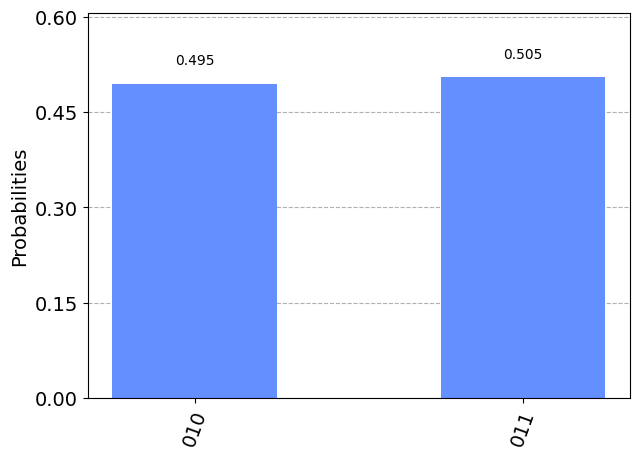

In [298]:
plot_histogram(circ_without_noise(circ, num_shots))

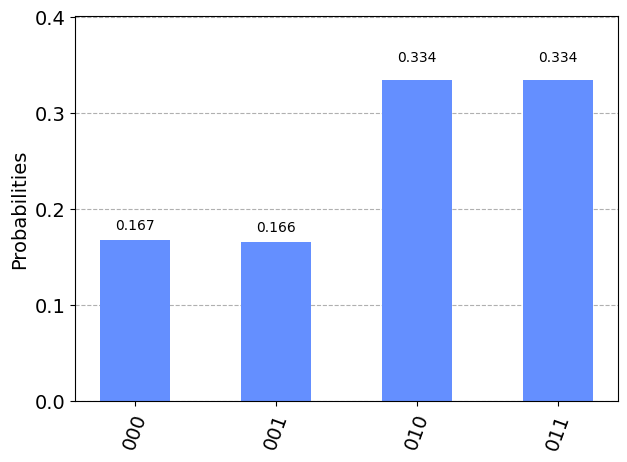

In [299]:
plot_histogram(circ_with_noise(circ, noise_model, num_shots))

running...
searching...
terminating...
        ░ ┌───┐┌───┐┌───┐ ░ ┌───┐     ┌───┐     ┌───┐      ░ ┌───┐      ░    
  a_0: ─░─┤ H ├┤ X ├┤ H ├─░─┤ H ├──■──┤ H ├──■──┤ H ├──■───░─┤ X ├──────░────
        ░ └───┘└─┬─┘└───┘ ░ └───┘┌─┴─┐└───┘┌─┴─┐└───┘┌─┴─┐ ░ └─┬─┘      ░    
  a_1: ─░────────┼────────░──────┤ X ├─────┤ X ├─────┤ X ├─░───┼────────░────
        ░        │        ░      └───┘     └───┘     └───┘ ░   │        ░    
  a_2: ─░────────┼────────░────────────────────────────────░───┼────────░────
        ░ ┌───┐  │        ░                                ░   │  ┌───┐ ░ ┌─┐
    b: ─░─┤ H ├──■────────░────────────────────────────────░───■──┤ H ├─░─┤M├
        ░ └───┘           ░                                ░      └───┘ ░ └╥┘
c69: 1/════════════════════════════════════════════════════════════════════╩═
                                                                           0 
total execution time 0.26924705505371094
done
{'000 0': 1004, '001 0': 1000, '010 1': 1108, '010 0': 17

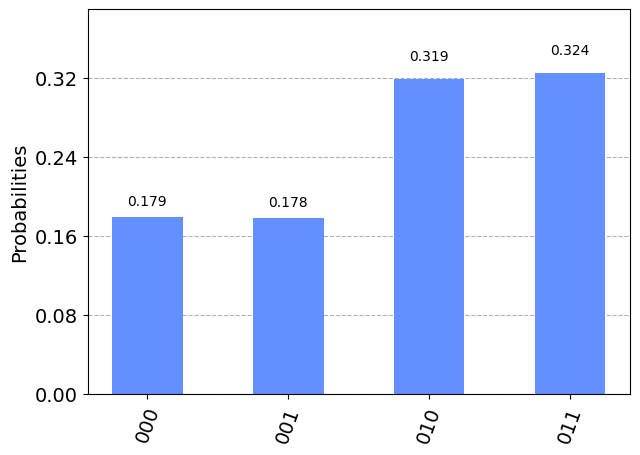

In [301]:
count = circ_with_noise_pcs(circ, noise_model, 1, num_shots)

print(sum(count.values())/num_shots)
plot_histogram(count)